In [1]:
#loading python classes and packages
from ultralytics import YOLO
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, LSTM
from keras.layers import Conv2D
from keras.models import Sequential, load_model, Model
from sklearn.metrics import classification_report
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading sign language dataset images
path = "Data/images/train"
sign_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
               'Z', 'Apple', 'Can', 'Get', 'Good', 'Give me a call', 'I love you', 'I want money', 'I want to go to the washroom', 
               'Please stop', 'Thank you very much']
X = []
Y = []
if os.path.exists("model/X.npy"): #if dataset already process then load them
    X = np.load('model/X.npy')
    Y = np.load('model/Y.npy')
else: #if dataset not yet processed then loop each image and extract features
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            img = cv2.imread(root+"/"+directory[j])#read each image
            img = cv2.resize(img, (32, 32))
            name = directory[j].replace(".jpg", ".txt")
            name = "Data/labels/train/"+name
            with open(name,"rb") as file:#read image class label
                data = file.read()
            file.close()
            data = data.decode()
            data = data.split(" ")
            X.append(img)
            Y.append(int(data[0].strip()))
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X',X)
    np.save('model/Y',Y)
print("Dataset Loading Completed")
print("Total images found in dataset = "+str(X.shape[0]))

Dataset Loading Completed
Total images found in dataset = 2332


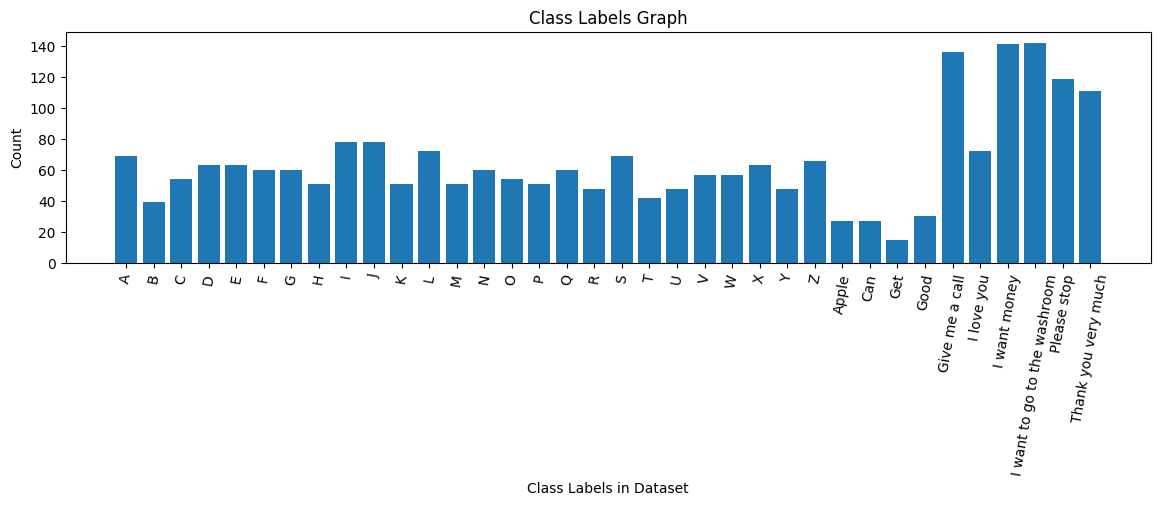

In [6]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = sign_labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (14, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Class Labels in Dataset")
plt.ylabel("Count")
plt.title("Class Labels Graph")
plt.xticks(rotation=80)
plt.show()

In [7]:
#yolo confidence threshold to detect hand signs
CONFIDENCE_THRESHOLD = 0.50
GREEN = (0, 255, 0)
yolo_model = YOLO("model/yolo11_best.pt")
print("Yolo11 Model Loaded")

Yolo11 Model Loaded


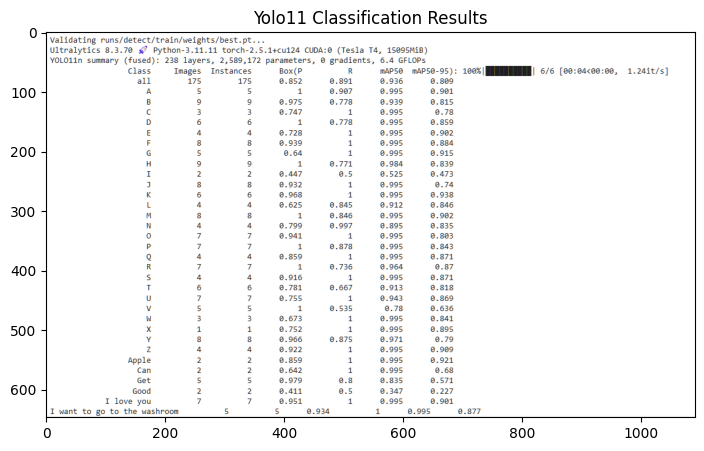

In [8]:
#yolo11 classification results
data = cv2.imread("model/yolo11_result.png")
plt.figure(figsize=(10, 5))
plt.imshow(data)
plt.title("Yolo11 Classification Results")
plt.show()

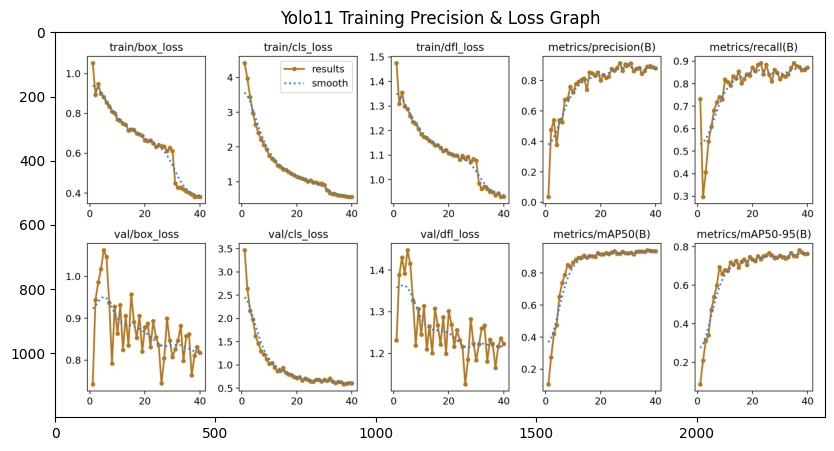

In [9]:
#yolo11 classification results
data = cv2.imread("model/yolo11_results.png")
plt.figure(figsize=(10, 5))
plt.imshow(data)
plt.title("Yolo11 Training Precision & Loss Graph")
plt.show()

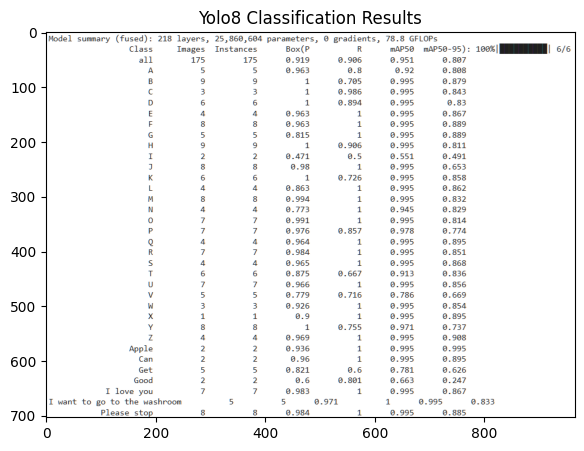

In [10]:
#yolo8 classification results
data = cv2.imread("model/yolo8_result.png")
plt.figure(figsize=(10, 5))
plt.imshow(data)
plt.title("Yolo8 Classification Results")
plt.show()

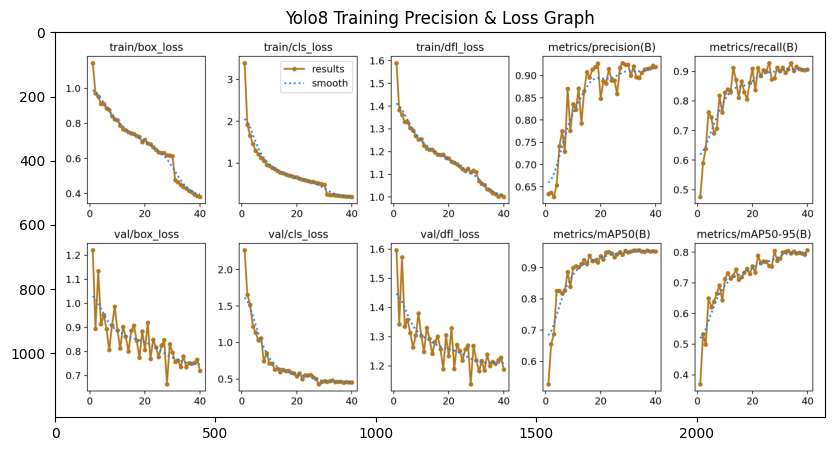

In [11]:
#yolo11 classification results
data = cv2.imread("model/yolo8_results.png")
plt.figure(figsize=(10, 5))
plt.imshow(data)
plt.title("Yolo8 Training Precision & Loss Graph")
plt.show()

In [12]:
#function to detect signs using YOLO11
def detectSign(frame):
    global yolo_model
    detections = yolo_model(frame)[0]
    label = None
    # loop over the detections
    for data in detections.boxes.data.tolist():
        print(data)
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]
        cls_id = data[5]
        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) >= CONFIDENCE_THRESHOLD:
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            label = sign_labels[int(cls_id)]
            cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), GREEN, 2)
            cv2.putText(frame, sign_labels[int(cls_id)], (xmin, ymin-10),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)            
    return frame, label

In [13]:
#dataset processing such as shuffling, normalization and splittig into train and test
X = np.reshape(X, (X.shape[0], 1, X.shape[1], X.shape[2], X.shape[3]))
X = X.astype('float32')
X = X/255 #normalize image features
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle images
X = X[indices]
Y = Y[indices]        
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Train & Test Split Details")
print("80% images files used to train algorithms : "+str(X_train.shape[0]))
print("20% images files used to test algorithms : "+str(X_test.shape[0]))

Dataset Train & Test Split Details
80% images files used to train algorithms : 1865
20% images files used to test algorithms : 467


In [14]:
stgcn_model = Sequential()
#defining CNN layer as CNN Can learn features from both spatial and temporal time dimensions
#CNN's output can extract spatial features from input data and then generate graph based features with node and edges
stgcn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (1, 32, 32, 3)))
stgcn_model.add(TimeDistributed(MaxPooling2D((4, 4))))
stgcn_model.add(Dropout(0.3))
stgcn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
stgcn_model.add(TimeDistributed(MaxPooling2D((4, 4))))
stgcn_model.add(Dropout(0.3))
stgcn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
stgcn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
stgcn_model.add(Dropout(0.3))
stgcn_model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
stgcn_model.add(TimeDistributed(MaxPooling2D((1, 1))))
stgcn_model.add(Dropout(0.3))
stgcn_model.add(TimeDistributed(Flatten()))
#LSTM Can learn long-term dependencies in sequential data by looping over time steps.
#In a CNN-LSTM network, the LSTM can capture temporal dependencies between input data.
stgcn_model.add(LSTM(32))#adding LSTM layer
stgcn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
stgcn_model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/st_weights.keras") == False:
    model_check_point = ModelCheckpoint(filepath='model/st_weights.keras', verbose = 1, save_best_only = True)
    hist = stgcn_model.fit(X_train, y_train, batch_size = 32, epochs = 300, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/st_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    stgcn_model.load_weights("model/st_weights.keras")
predict = stgcn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print("Spatio Temporal Graph Neural Network Classification Result")
print(classification_report(y_test1, predict, target_names=sign_labels))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 
Spatio Temporal Graph Neural Network Classification Result
                              precision    recall  f1-score   support

                           A       0.93      1.00      0.96        13
                           B       0.89      0.89      0.89         9
                           C       1.00      0.92      0.96        13
                           D       1.00      0.90      0.95        10
                           E       0.88      1.00      0.93         7
                           F       0.86      1.00      0.92         6
                           G       0.88      1.00      0.94        15
                           H       1.00      1.00      1.00         7
                           I       0.94      0.79      0.86        19
                           J       1.00      1.00      1.00        19
                           K       1.00      0.90      0.95        10
                           L       0.88      0.93      0.90